# 🤖 Sentiment analysis of PPGIS data

In [ ]:
%pip install torch transformers -q

In [2]:
import duckdb
import pandas as pd
import geopandas as gpd
import osmnx as ox

from transformers import pipeline

import plotly.express as px

# load duckdb spatial extension
duckdb.sql('LOAD spatial')

In [4]:
# describe data from parquet file
query = """
SUMMARIZE TABLE './data/mock_ppgis_data.parquet';
"""

duckdb.sql(query)

┌─────────────┬─────────────┬──────────────────────────────────────────────┬──────────────────────────────────────────────┬───────────────┬─────────┬────────────────────┬─────────┬─────────┬─────────┬───────┬─────────────────┐
│ column_name │ column_type │                     min                      │                     max                      │ approx_unique │   avg   │        std         │   q25   │   q50   │   q75   │ count │ null_percentage │
│   varchar   │   varchar   │                   varchar                    │                   varchar                    │     int64     │ varchar │      varchar       │ varchar │ varchar │ varchar │ int64 │  decimal(9,2)   │
├─────────────┼─────────────┼──────────────────────────────────────────────┼──────────────────────────────────────────────┼───────────────┼─────────┼────────────────────┼─────────┼─────────┼─────────┼───────┼─────────────────┤
│ id          │ BIGINT      │ 1                                            │ 1000           

1000
    id                                            comment  \
0  361  The new biking trails are a game-changer. So s...   
1  126               Why are the sidewalks always so icy?   
2  261  Keskustori always has such a lively vibe. A mu...   
3  813  The construction noise on Itsenäisyydenkatu ru...   
4  652               Why are the sidewalks always so icy?   

                    geometry  
0  POINT (23.77382 61.48137)  
1  POINT (23.85580 61.48994)  
2  POINT (23.67978 61.52243)  
3  POINT (23.78402 61.47140)  
4  POINT (23.73124 61.50321)  


<Axes: >

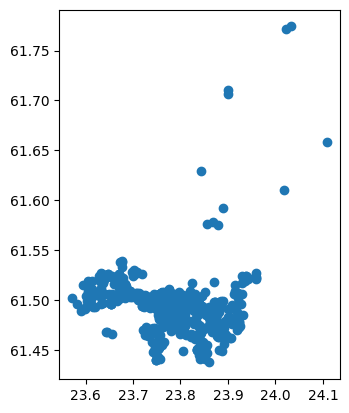

In [5]:
# read data from parquet file
# Finland base CRS = 3067 

query = """
SELECT *, ST_AsText(centroid) as geometry from './data/mock_ppgis_data.parquet';
"""

ppgis_df = duckdb.sql(query).df().drop(columns=['centroid'])
ppgis_gdf = gpd.GeoDataFrame(ppgis_df, geometry=gpd.GeoSeries.from_wkt(ppgis_df['geometry']), crs='EPSG:3067')
ppgis_gdf = ppgis_gdf.to_crs('EPSG:4326')
print(len(ppgis_gdf))
print(ppgis_gdf.head())
ppgis_gdf.plot()

In [ ]:
# download a pre-trained model from hugging face

# define task and model
sentiment_pipeline = pipeline(task="sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

In [7]:
# test the model to see what are its outputs
sentiment_pipeline("asphalt ocean, zero excitement #meh")

[{'label': 'negative', 'score': 0.6543532609939575}]

In [8]:
# apply the model to the comments in the data
ppgis_gdf['sentiment'] = ppgis_gdf['comment'].apply(lambda com: sentiment_pipeline(com)[0]['label'])

# check the results
ppgis_gdf['sentiment'].value_counts()

sentiment
positive    514
negative    486
Name: count, dtype: int64

In [ ]:
ppgis_gdf.explore(column='sentiment', categorical=True, marker_kwds={'radius':5}, style_kwds={'fillOpacity': 1})